# Denoising Pipeline Development

In [ ]:
%load_ext autoreload
%autoreload 2

import fibsem
import salami
from fibsem import utils, acquire, alignment, calibration, milling
from fibsem.structures import BeamType, FibsemPatternSettings, FibsemMillingSettings, FibsemPattern
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

from salami.structures import SalamiSettings, run_salami, create_sweep_parameters



In [ ]:
microscope, settings = utils.setup_session()


In [ ]:
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")
plt.show()


### Move Raw Images to a New Directory

In [ ]:
%load_ext autoreload
%autoreload 2

import glob
import os
from pathlib import Path


path = "/home/patrick/github/salami/salami/denoise/raw_imgs"
slow_filenames = sorted(glob.glob(os.path.join(path, "*5e-06*.tif")))
fast_filenames = sorted(glob.glob(os.path.join(path, "*5e-07*.tif")))


from pprint import pprint
raw_path = "/home/patrick/github/salami/data/20230310/raw"


os.makedirs(os.path.join(raw_path, "slow"), exist_ok=True)
os.makedirs(os.path.join(raw_path, "fast"), exist_ok=True)

for fname in fast_filenames:

    idx = int(os.path.splitext(os.path.basename(fname))[0].split("_")[1])
    print(os.path.join(raw_path, "fast",  f"{idx:06d}.tif"))

    # copy file with os
    # os.system(f"cp {fname} {os.path.join(raw_path, 'fast',  f'{idx:06d}.tif')}")




In [ ]:

raw_path = "/home/patrick/github/salami/data/20230310/raw"

fast_filenames = sorted(glob.glob(os.path.join(raw_path, "fast", "*.tif")))
slow_filenames = sorted(glob.glob(os.path.join(raw_path, "slow", "*.tif")))


from pprint import pprint

# pprint(fast_filenames)

import math

from salami.denoise.inference import get_window, get_index, get_closest_index

window_size = 5
for idx, fname in enumerate(fast_filenames):

    # idx = get_index(fname) # this is based on the fname which means nothing
    window = get_window(fast_filenames, idx, window_size=window_size)
    if len(window) < window_size:
        continue
    # closest = get_closest_index(window, idx)
    # print(f"index: {idx}, closest: {get_index(closest)}")
    print(f"index: {idx}, window: {[get_index(f) for f in window]}")
    # print(window)
    

## Segmentation Diagnostics

In [ ]:
%load_ext autoreload
%autoreload 2

import os
from salami.segmentation import segmentation as sseg

path = "/home/patrick/github/salami/salami/output/seg"

stats = sseg.calc_seg_diagnostic(path, plot=True)

In [ ]:
print(stats["counts"].shape)

In [ ]:
df = sseg.calculate_diag_df(stats)
display(df)

In [ ]:
# plot the counts

# get column names except fname

labels = df.columns[:-1]
df.plot(x="fname", y=labels, kind="line", figsize=(10,5)) 
# df.plot(x="fname", y=stats["labels"], kind="line", figsize=(10,5))

## WatchDog Testing

In [ ]:
%load_ext autoreload
%autoreload 2

import glob
import os
from pathlib import Path


path = "/home/patrick/github/salami/salami/denoise/raw_imgs"
# slow_filenames = sorted(glob.glob(os.path.join(path, "*5e-06*.tif")))
fast_filenames = sorted(glob.glob(os.path.join(path, "*5e-07*.tif")))


from pprint import pprint
raw_path = "/home/patrick/github/salami/salami/output2/raw"

# os.makedirs(os.path.join(raw_path, "slow"), exist_ok=True)
os.makedirs(raw_path, exist_ok=True)
import time
for fname in fast_filenames:

    idx = int(os.path.splitext(os.path.basename(fname))[0].split("_")[1])
    print(os.path.join(raw_path, f"{idx:06d}.tif"))

    # copy file with os
    os.system(f"cp {fname} {os.path.join(raw_path, f'{idx:06d}.tif')}")

    time.sleep(0.5)


In [ ]:
# simulate latency of 45sec vs 12 sec
# plot a graph of 1 image per 12 sec vs 1 image per 45 sec

# 1 per 12
# 1 per 45

fps12 = 1 / 12 # frames per seconds
fps45 = 1 / 45 # frames per seconds 

print(fps12, fps45)

import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 1000, 1)
y1 = fps12 * x
y2 = fps45 * x

plt.plot(x, y1, label="12 spf")
plt.plot(x, y2, label="45 spf")
# difference
plt.plot(x, y1 - y2, label="difference")
plt.xlabel("number of seconds")
plt.ylabel("number of images")
plt.legend()
plt.show()

In [ ]:
from salami.denoise.frame import *
import matplotlib.pyplot as plt

# how to calculate FRC between to images & calculate PSNR

# load image, split in half save files
from fibsem.structures import FibsemImage
import tifffile as tff

import glob
path = "/home/patrick/github/data/salami/analysis/2023-04-14-07-05-07PM/data"
filenames = sorted(glob.glob(os.path.join(path, "*.tif")))

for fname in filenames:


    img = FibsemImage.load(fname)

    # split in half
    img1 = img.data[:, :img.data.shape[1]//2]
    img2 = img.data[:, img.data.shape[1]//2:]

    # save
    tmp_dir = os.path.join(os.path.dirname(fname), "tmp")
    os.makedirs(tmp_dir, exist_ok=True)

    fname1 = os.path.join(tmp_dir, "tmp1.tif")
    fname2 = os.path.join(tmp_dir, "tmp2.tif")
    tff.imwrite(fname1, img1)
    tff.imwrite(fname2, img2)


    # read
    img1 = Frame(filename=fname1)
    img2 = Frame(filename=fname2)

    # remove borders
    border = 128
    img1 = img1.clip(border, border, border, border)
    img2 = img2.clip(border, border, border, border)

    # PSNR
    psnr = img1.calcPSNR(img2)

    # FRC
    # image normalization, masking, Fourier transformation
    img1.normalize()
    img1.taperEdges(0.95)  # rectangular Tukey windowing (= cosine edge)
    img1.fft()

    img2.normalize()
    img2.taperEdges(0.95)  # rectangular Tukey windowing (= cosine edge)
    img2.fft()

    # actual calculation & plot
    g, frc = img1.calcFRC(img2)


    # subplot image and metric
    import matplotlib.pyplot as plt
    print(f"{os.path.basename(fname)}, {img.data.shape}, PSNR: {psnr:.2f}")

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(img.data, cmap="gray")
    ax[1].plot(g, frc)
    plt.show()

# TODO: port this to not use the Frame class
# TODO: getting negative values?
# TODO: need to understand what is happening


## Analysis Pipeline

In [ ]:
%load_ext autoreload
%autoreload 2

from salami import analysis as sa
from fibsem.structures import FibsemImage

import os
import glob

from scipy import ndimage
import matplotlib.pyplot as plt

import pandas as pd
import os
import glob
from tqdm import tqdm



In [ ]:

# scipy median filter

# x axis = 1 / nm

path = "/home/patrick/github/data/salami/analysis/2023-04-14-07-05-07PM/data"

save_path = os.path.join(os.getcwd(), "notebook_test")
os.makedirs(save_path, exist_ok=True)

filenames = sorted(glob.glob(os.path.join(path, "*.tif")))

# load the images
for fname in filenames[:20]:
    img = FibsemImage.load(fname)

    metric, (h00, h01, h10, h11) = sa.calculate_halfmap_frc(img.data)

    print(f"{os.path.basename(fname)}: {img.data.shape}")

    # subplot image and metric
    mean_frc = sa.get_frc_metric(metric)

    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].imshow(img.data, cmap="gray")
    ax[1].imshow(h00, cmap="gray")
    ax[2].imshow(h11, cmap="gray")
    ax[3].plot(metric[0], label="h0")
    ax[3].plot(metric[1], label="h1")
    # ax[3].plot(, label="mean")
    ax[3].plot(ndimage.median_filter(mean_frc, size=5), label="mean (filtered)")
    ax[3].legend(loc="best")
    
    
    # save figure
    plt.savefig(os.path.join(save_path, f"{os.path.basename(fname)}.png"))
    plt.show()


    # break


Calculating FRC: 000000_eb.tif, split: checkerboard:   0%|          | 0/90 [00:00<?, ?it/s]

000000_eb.tif: (1024, 1536)


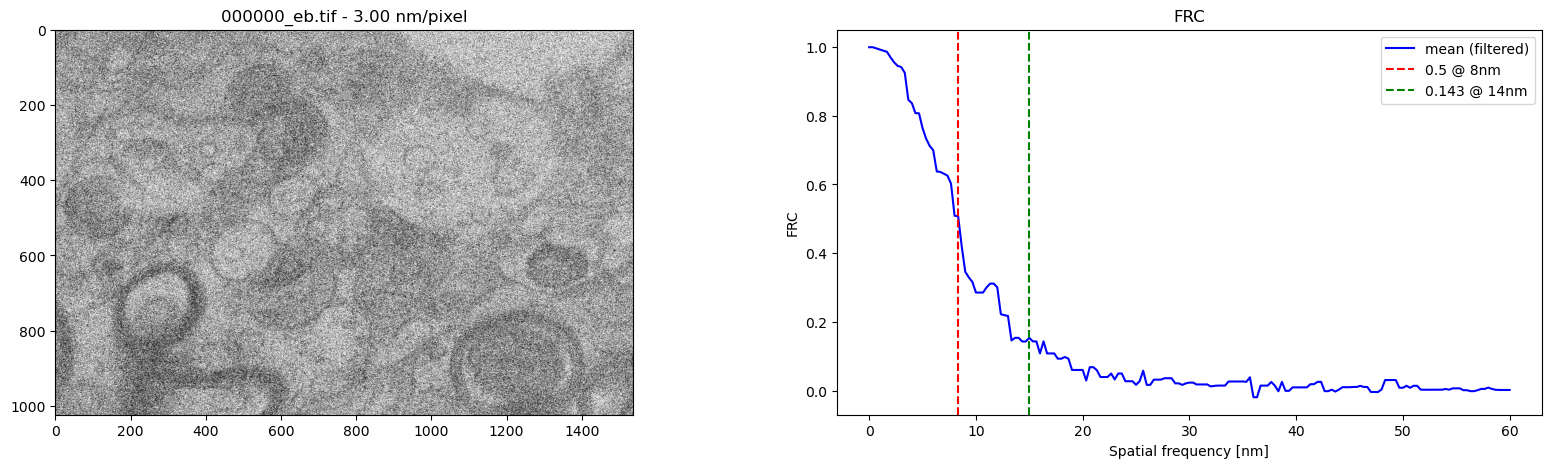

Calculating FRC: 000001_eb.tif, split: checkerboard:   1%|          | 1/90 [00:07<11:40,  7.87s/it]

000001_eb.tif: (1024, 1536)


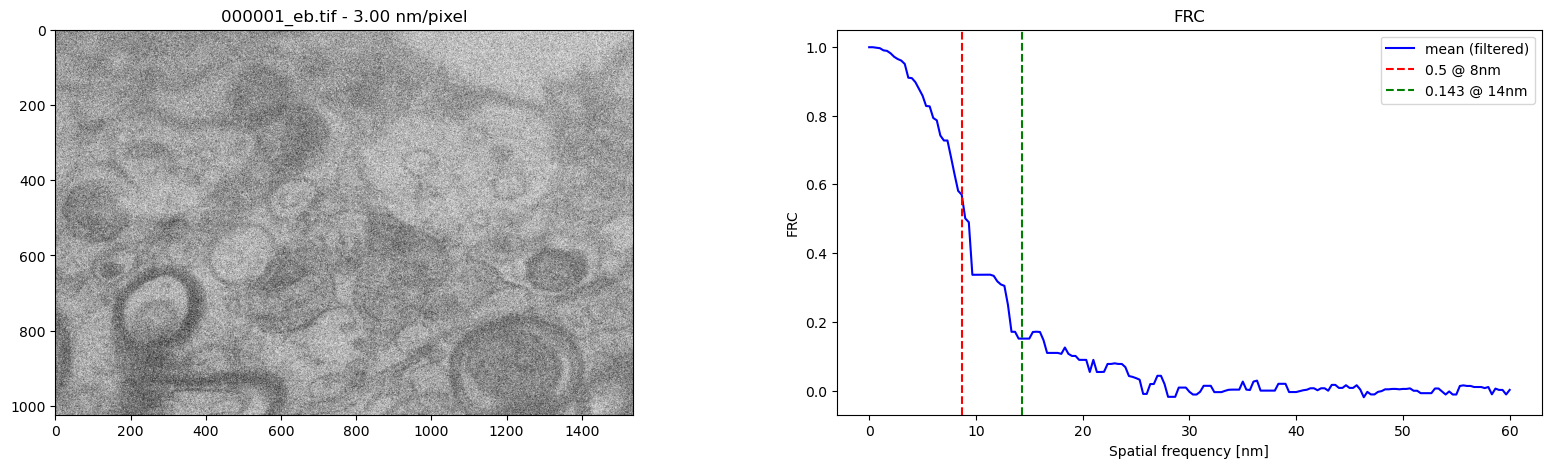

Calculating FRC: 000002_eb.tif, split: checkerboard:   2%|▏         | 2/90 [00:15<11:11,  7.63s/it]

000002_eb.tif: (1024, 1536)


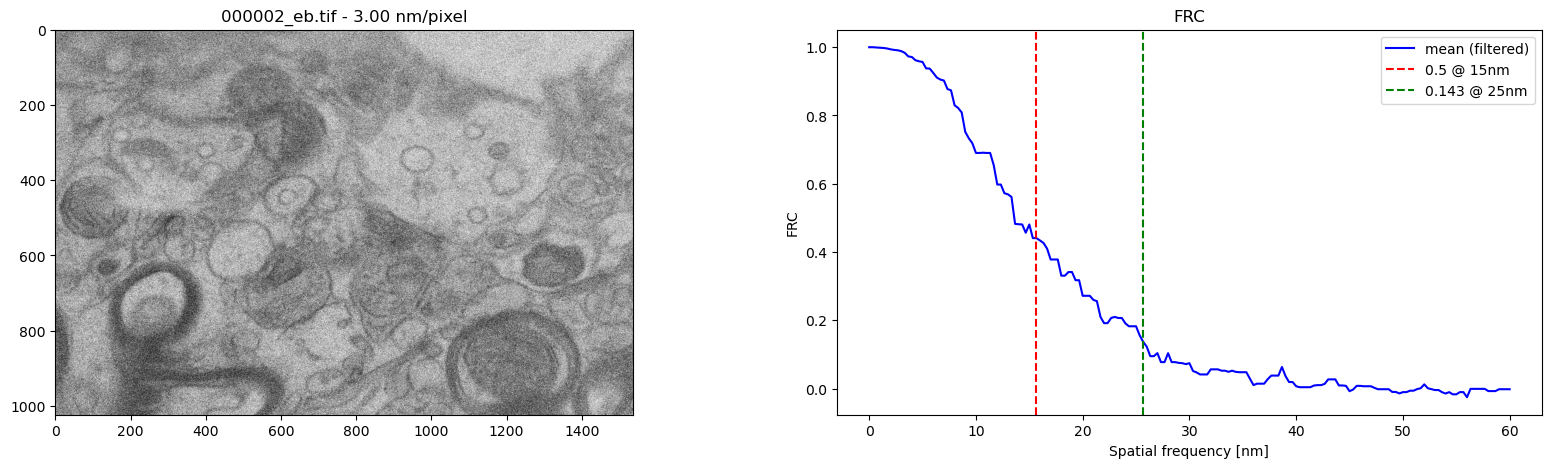

Calculating FRC: 000003_eb.tif, split: checkerboard:   3%|▎         | 3/90 [00:22<10:52,  7.50s/it]

000003_eb.tif: (1024, 1536)


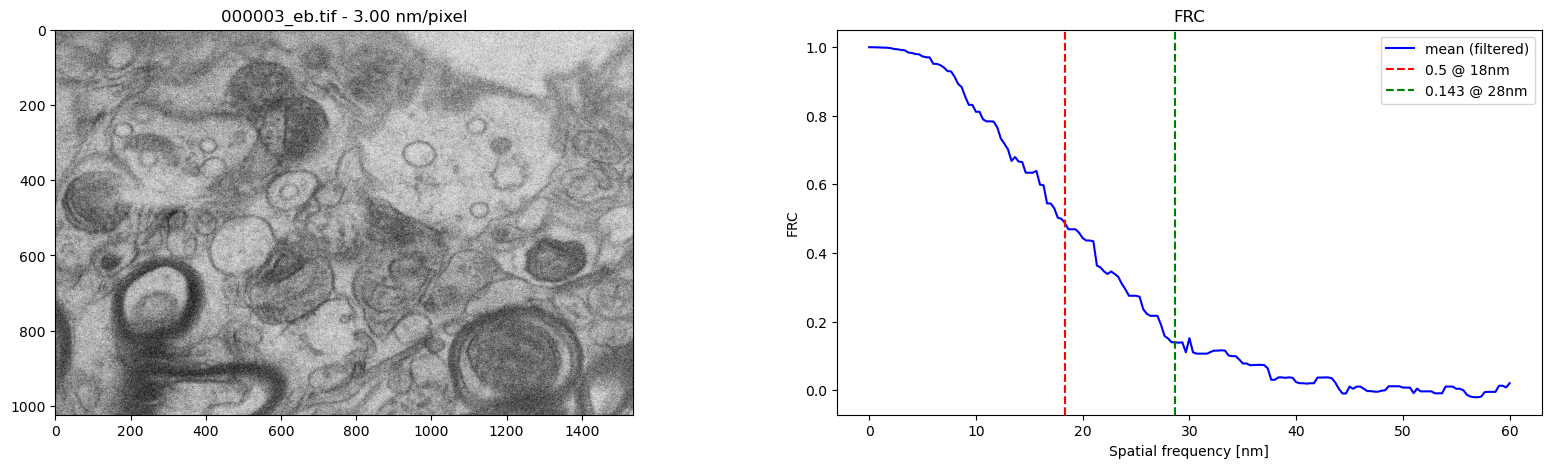

Calculating FRC: 000004_eb.tif, split: checkerboard:   4%|▍         | 4/90 [00:29<10:25,  7.27s/it]

000004_eb.tif: (1024, 1536)


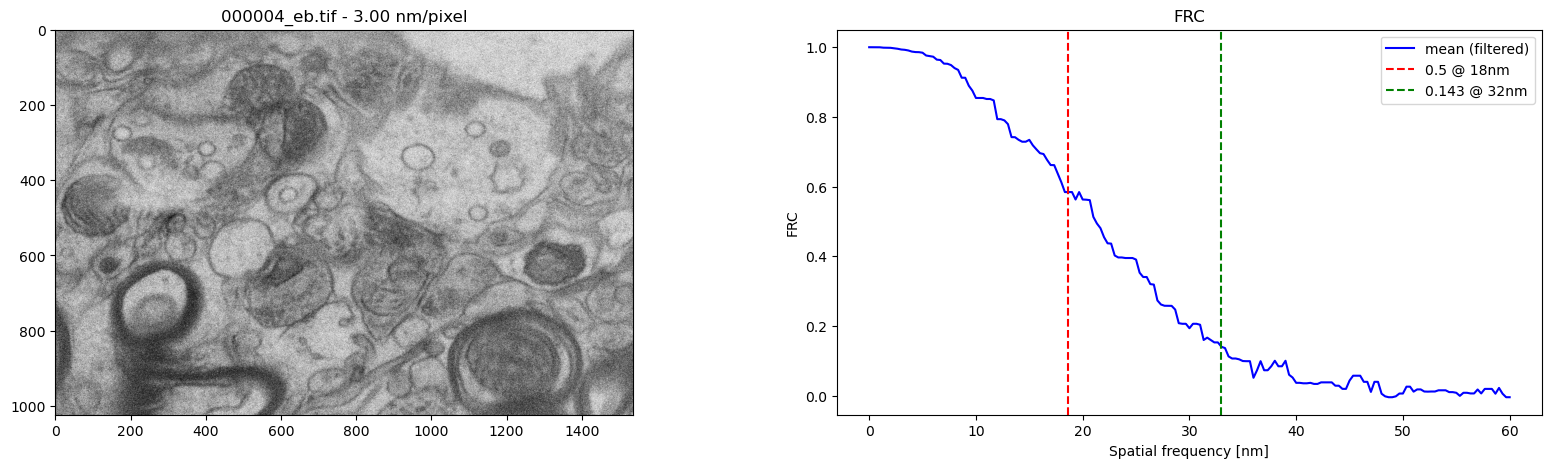

Calculating FRC: 000005_eb.tif, split: checkerboard:   6%|▌         | 5/90 [00:36<10:19,  7.29s/it]

000005_eb.tif: (1024, 1536)


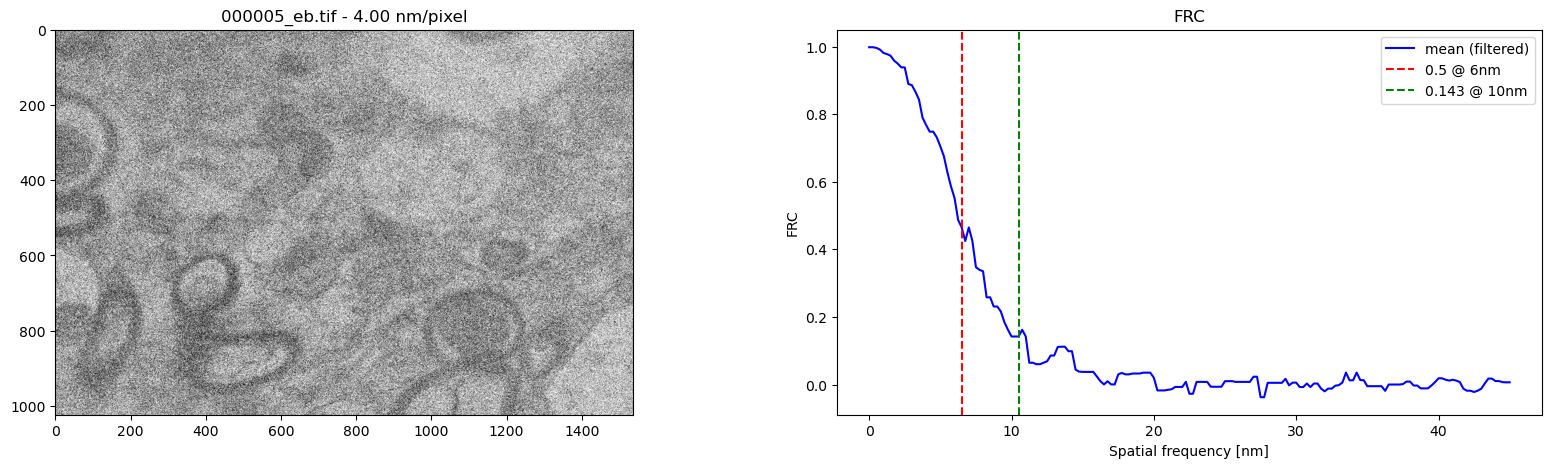

Calculating FRC: 000006_eb.tif, split: checkerboard:   7%|▋         | 6/90 [00:44<10:12,  7.29s/it]

000006_eb.tif: (1024, 1536)


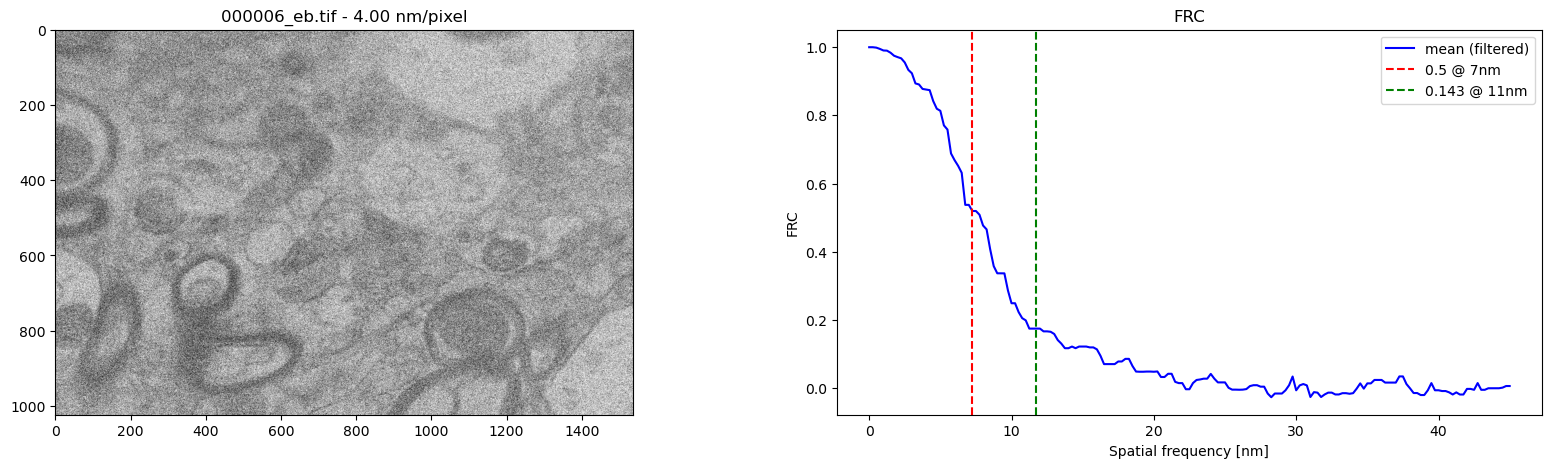

Calculating FRC: 000007_eb.tif, split: checkerboard:   8%|▊         | 7/90 [00:52<10:28,  7.58s/it]

In [162]:

df = pd.read_csv(os.path.join(path, "parameters.csv"))

params_dict = df.to_dict("records")

path_data = []
prog = tqdm(params_dict)
split_strat  = "checkerboard"
for parameters in prog:
    idx = parameters["idx"]
    pixelsize = parameters["pixelsize"]

    fname = glob.glob(os.path.join(path, f"{idx:06d}*.tif"))[0]
    basename = os.path.basename(fname)
    prog.set_description(f"Calculating FRC: {basename}, split: {split_strat}")

    img = FibsemImage.load(fname)

    metric, (h00, h01, h10, h11) = sa.calculate_halfmap_frc(img.data)

    print(f"{os.path.basename(fname)}: {img.data.shape}")

    # subplot image and metric
    mean_frc = sa.get_frc_mean(metric)

    # scale x axis by pixelsize
    x = np.arange(len(mean_frc)) / pixelsize
    int_05 = x[np.argmin(np.abs(mean_frc - 0.5))]
    int_0143 = x[np.argmin(np.abs(mean_frc - 0.143))]

    fig, ax = plt.subplots(1,2, figsize=(20,5))
    ax[0].imshow(img.data, cmap="gray")
    ax[0].set_title(f"{basename} - {pixelsize:.2f} nm/pixel")
    # ax[1].plot(x, metric[0], label="h0")
    # ax[1].plot(x, metric[1], label="h1")
    ax[1].plot(x ,ndimage.median_filter(mean_frc, size=5), color="blue", label="mean (filtered)")
    ax[1].set_title(f"FRC")
    ax[1].set_xlabel("Spatial frequency [nm]")
    ax[1].set_ylabel("FRC")

    # plot where the FRC is 0.5, 0.143
    ax[1].axvline(int_05, color="red", linestyle="--", label=f"0.5 @ {int(int_05):d}nm")
    ax[1].axvline(int_0143, color="green", linestyle="--", label=f"0.143 @ {int(int_0143):d}nm")

    ax[1].legend(loc="best")
    
    # save figure
    plt.savefig(os.path.join(save_path, f"{os.path.basename(fname)}.png"))
    plt.show()

    path_data.append([idx, basename, mean_frc, int_05, int_0143])


# save metrics
df = pd.DataFrame(path_data, columns=["idx", "basename", "metric", "int_05", "int_0143"])
df.to_csv(os.path.join(path, "metrics.csv"), index=False)

display(df)



In [ ]:
df = pd.read_csv(os.path.join(path, "metrics.csv"))

In [ ]:
# create checkerboard mask 1px wide
image = np.zeros((8, 8))

mask = np.zeros_like(image, dtype=bool)
mask[::2, ::2] = 1
mask[1::2, 1::2] = 1

mask = mask.astype(int)

idx = [x for x in range(0, mask.shape[0]) if x % 2 == 1]

for i in idx:
    print(i, mask[i, :])
    mask[i, :] = 2 * mask[i,  :]

# plot
import matplotlib.pyplot as plt

plt.imshow(mask, cmap="gray")
plt.colorbar()
plt.show()


mask2 = mask == 0
mask2 = mask2.astype(int)

idx = [x for x in range(0, mask2.shape[0]) if x % 2 == 1]

for i in idx:
    print(i, mask2[i, :])
    mask2[i, :] = 2 * mask2[i,  :]


m00 = mask == 1
m01 = mask == 2

m10 = mask2 == 1
m11 = mask2 == 2

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(m00)
ax[0,1].imshow(m01)
ax[1,0].imshow(m10)
ax[1,1].imshow(m11)
plt.show()

